In [1]:
!pip install ipynb
import ipynb
import numpy as np

In [2]:
from ipynb.fs.defs.speck import make_train_data
from ipynb.fs.defs.speck import real_differences_data


In [3]:
import keras
import matplotlib.pyplot as plt

from keras.models import Model
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Dense,Conv1D,Input,Reshape,Add,Flatten,Concatenate,Permute,BatchNormalization,Activation,AveragePooling1D

In [4]:
def cyclic_lr(num_epochs, high_lr, low_lr):
  res = lambda i: low_lr + ((num_epochs-1) - i % num_epochs)/(num_epochs-1) * (high_lr - low_lr);
  return(res)

lr = LearningRateScheduler(cyclic_lr(10,0.002, 0.0001))

In [6]:
def transition_block(x, compression_factor=1,reg_param=0.0001,num_filters=32):
    # Batch normalization
    x = BatchNormalization()(x)
    # Convolutional layer
    x = Conv1D(num_filters, kernel_size=1,kernel_regularizer=l2(reg_param))(x)
    #activation
    x=Activation('relu')(x)
    # Downsampling using average pooling
    x = AveragePooling1D(pool_size=1)(x)



    return x
def densenet(num_blocks=2, num_filters=32, num_outputs=1, d1=64, d2=64, word_size=16, ks=3,depth=8, reg_param=0.0001, final_activation='sigmoid'):
  #Input and preprocessing layers
  inp = Input(shape=(num_blocks * word_size * 2,));
  rs = Reshape((2 * num_blocks, word_size))(inp);
  perm = Permute((2,1))(rs);
  #add a single residual layer that will expand the data to num_filters channels
  #this is a bit-sliced layer
  conv0 = Conv1D(num_filters, kernel_size=1, padding='same', kernel_regularizer=l2(reg_param))(perm);
  conv0 = BatchNormalization()(conv0);
  conv0 = Activation('relu')(conv0);
  #add residual blocks
  x1 = conv0;
  def dense_block(x,depth):
    for i in range(depth):

        x1 = Conv1D(64, kernel_size=3, padding='same',kernel_regularizer=l2(reg_param))(x)
        x1 = BatchNormalization()(x1)
        x1 = Activation('relu')(x1)

        x1 = Conv1D(64, kernel_size=3, padding='same',kernel_regularizer=l2(reg_param))(x1)
        x1 = BatchNormalization()(x1)
        x1 = Activation('relu')(x1)

        # x1 = Dense(64)(x1)
        # Concatenate the input with the output of the dense layer
        x = Concatenate()([x, x1])
        return x;


  for _ in range(2):
    x1=dense_block(x1,depth)
    x1=transition_block(x1)
  #final dense block
  x1=dense_block(x1,depth);

  # x1 = Conv1D(64, kernel_size=3, padding='same',kernel_regularizer=l2(reg_param))(x1)
  # x1 = BatchNormalization()(x1)
  # x1 = Activation('relu')(x1)
  #add prediction head
  flat1 = Flatten()(x1);
  dense1 = Dense(d1,kernel_regularizer=l2(reg_param))(flat1);
  dense1 = BatchNormalization()(dense1);
  dense1 = Activation('relu')(dense1);
  dense2 = Dense(d2, kernel_regularizer=l2(reg_param))(dense1);
  dense2 = BatchNormalization()(dense2);
  dense2 = Activation('relu')(dense2);
  out = Dense(num_outputs, activation=final_activation, kernel_regularizer=l2(reg_param))(dense2);
  model = Model(inputs=inp, outputs=out);
  return(model);


In [30]:
den=densenet()
den.compile(optimizer='adam',loss='mse',metrics=['acc'])
X,Y=make_train_data(1000000,nr=5)
x_test,y_test=real_differences_data(100000,nr=5)

In [31]:
history=den.fit(X,Y,epochs=20,batch_size=5000,callbacks=lr,validation_data=(x_test,y_test))

Epoch 1/20
200/200 [==============================] - 23s 67ms/step - loss: 0.1526 - acc: 0.8585 - val_loss: 0.3388 - val_acc: 0.4994 - lr: 0.0020
Epoch 2/20
200/200 [==============================] - 13s 65ms/step - loss: 0.1075 - acc: 0.8900 - val_loss: 0.3146 - val_acc: 0.5029 - lr: 0.0018
Epoch 3/20
200/200 [==============================] - 13s 66ms/step - loss: 0.0877 - acc: 0.9057 - val_loss: 0.3112 - val_acc: 0.5948 - lr: 0.0016
Epoch 4/20
200/200 [==============================] - 13s 65ms/step - loss: 0.0762 - acc: 0.9160 - val_loss: 0.3602 - val_acc: 0.5615 - lr: 0.0014
Epoch 5/20
200/200 [==============================] - 13s 64ms/step - loss: 0.0719 - acc: 0.9179 - val_loss: 0.2970 - val_acc: 0.6149 - lr: 0.0012
Epoch 6/20
200/200 [==============================] - 13s 64ms/step - loss: 0.0687 - acc: 0.9198 - val_loss: 0.2961 - val_acc: 0.6401 - lr: 9.4444e-04
Epoch 7/20
200/200 [==============================] - 13s 64ms/step - loss: 0.0657 - acc: 0.9224 - val_loss: 0.281

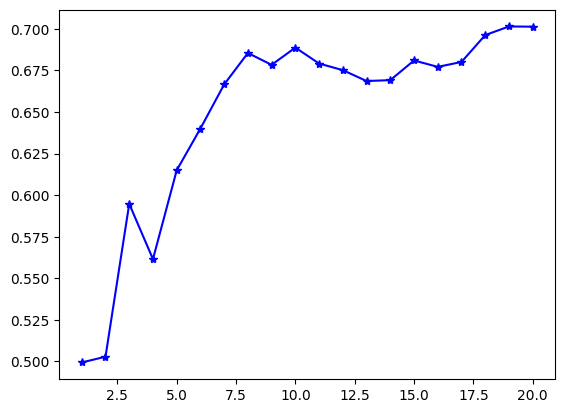

In [34]:
den_acc=history.history['val_acc']
epochs=range(1,21)
plt.plot(epochs,den_acc,'b*-')

In [23]:
def make_resnet(num_blocks=2, num_filters=32, num_outputs=1, d1=64, d2=64, word_size=16, ks=3,depth=10, reg_param=0.0001, final_activation='sigmoid'):
  #Input and preprocessing layers
  inp = Input(shape=(num_blocks * word_size * 2,));
  rs = Reshape((2 * num_blocks, word_size))(inp);
  perm = Permute((2,1))(rs);
  #add a single residual layer that will expand the data to num_filters channels
  #this is a bit-sliced layer
  conv0 = Conv1D(num_filters, kernel_size=1, padding='same', kernel_regularizer=l2(reg_param))(perm);
  conv0 = BatchNormalization()(conv0);
  conv0 = Activation('relu')(conv0);
  #add residual blocks
  shortcut = conv0;
  for i in range(depth):
    conv1 = Conv1D(num_filters, kernel_size=ks, padding='same', kernel_regularizer=l2(reg_param))(shortcut);
    conv1 = BatchNormalization()(conv1);
    conv1 = Activation('relu')(conv1);
    conv2 = Conv1D(num_filters, kernel_size=ks, padding='same',kernel_regularizer=l2(reg_param))(conv1);
    conv2 = BatchNormalization()(conv2);
    conv2 = Activation('relu')(conv2);
    shortcut = Add()([shortcut, conv2]);
  #add prediction head
  flat1 = Flatten()(shortcut);
  dense1 = Dense(d1,kernel_regularizer=l2(reg_param))(flat1);
  dense1 = BatchNormalization()(dense1);
  dense1 = Activation('relu')(dense1);
  dense2 = Dense(d2, kernel_regularizer=l2(reg_param))(dense1);
  dense2 = BatchNormalization()(dense2);
  dense2 = Activation('relu')(dense2);
  out = Dense(num_outputs, activation=final_activation, kernel_regularizer=l2(reg_param))(dense2);
  model = Model(inputs=inp, outputs=out);
  return(model);

In [33]:
res=make_resnet()

res.compile(optimizer='adam',loss='mse',metrics=['acc'])
X,Y=make_train_data(1000000,nr=5)
x_test,y_test=real_differences_data(100000,nr=5)
history2=res.fit(X,Y,epochs=20,batch_size=5000,callbacks=lr,validation_data=(x_test,y_test))

Epoch 1/20
200/200 [==============================] - 37s 91ms/step - loss: 0.1675 - acc: 0.8537 - val_loss: 0.3616 - val_acc: 0.4994 - lr: 0.0020
Epoch 2/20
200/200 [==============================] - 17s 83ms/step - loss: 0.1091 - acc: 0.8894 - val_loss: 0.4267 - val_acc: 0.4994 - lr: 0.0018
Epoch 3/20
200/200 [==============================] - 17s 84ms/step - loss: 0.0881 - acc: 0.9049 - val_loss: 0.3040 - val_acc: 0.5334 - lr: 0.0016
Epoch 4/20
200/200 [==============================] - 17s 83ms/step - loss: 0.0777 - acc: 0.9135 - val_loss: 0.3077 - val_acc: 0.5991 - lr: 0.0014
Epoch 5/20
200/200 [==============================] - 17s 84ms/step - loss: 0.0726 - acc: 0.9172 - val_loss: 0.3422 - val_acc: 0.5920 - lr: 0.0012
Epoch 6/20
200/200 [==============================] - 17s 84ms/step - loss: 0.0695 - acc: 0.9193 - val_loss: 0.3137 - val_acc: 0.6192 - lr: 9.4444e-04
Epoch 7/20
200/200 [==============================] - 17s 83ms/step - loss: 0.0671 - acc: 0.9215 - val_loss: 0.349

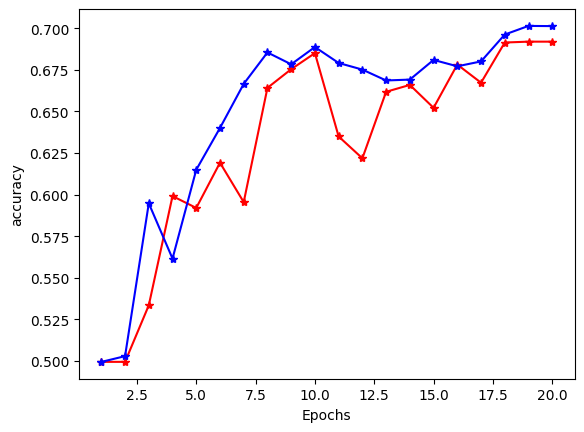

In [35]:
res_acc=history2.history['val_acc']
plt.plot(epochs,res_acc,'r*-')
plt.plot(epochs,den_acc,'b*-')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()